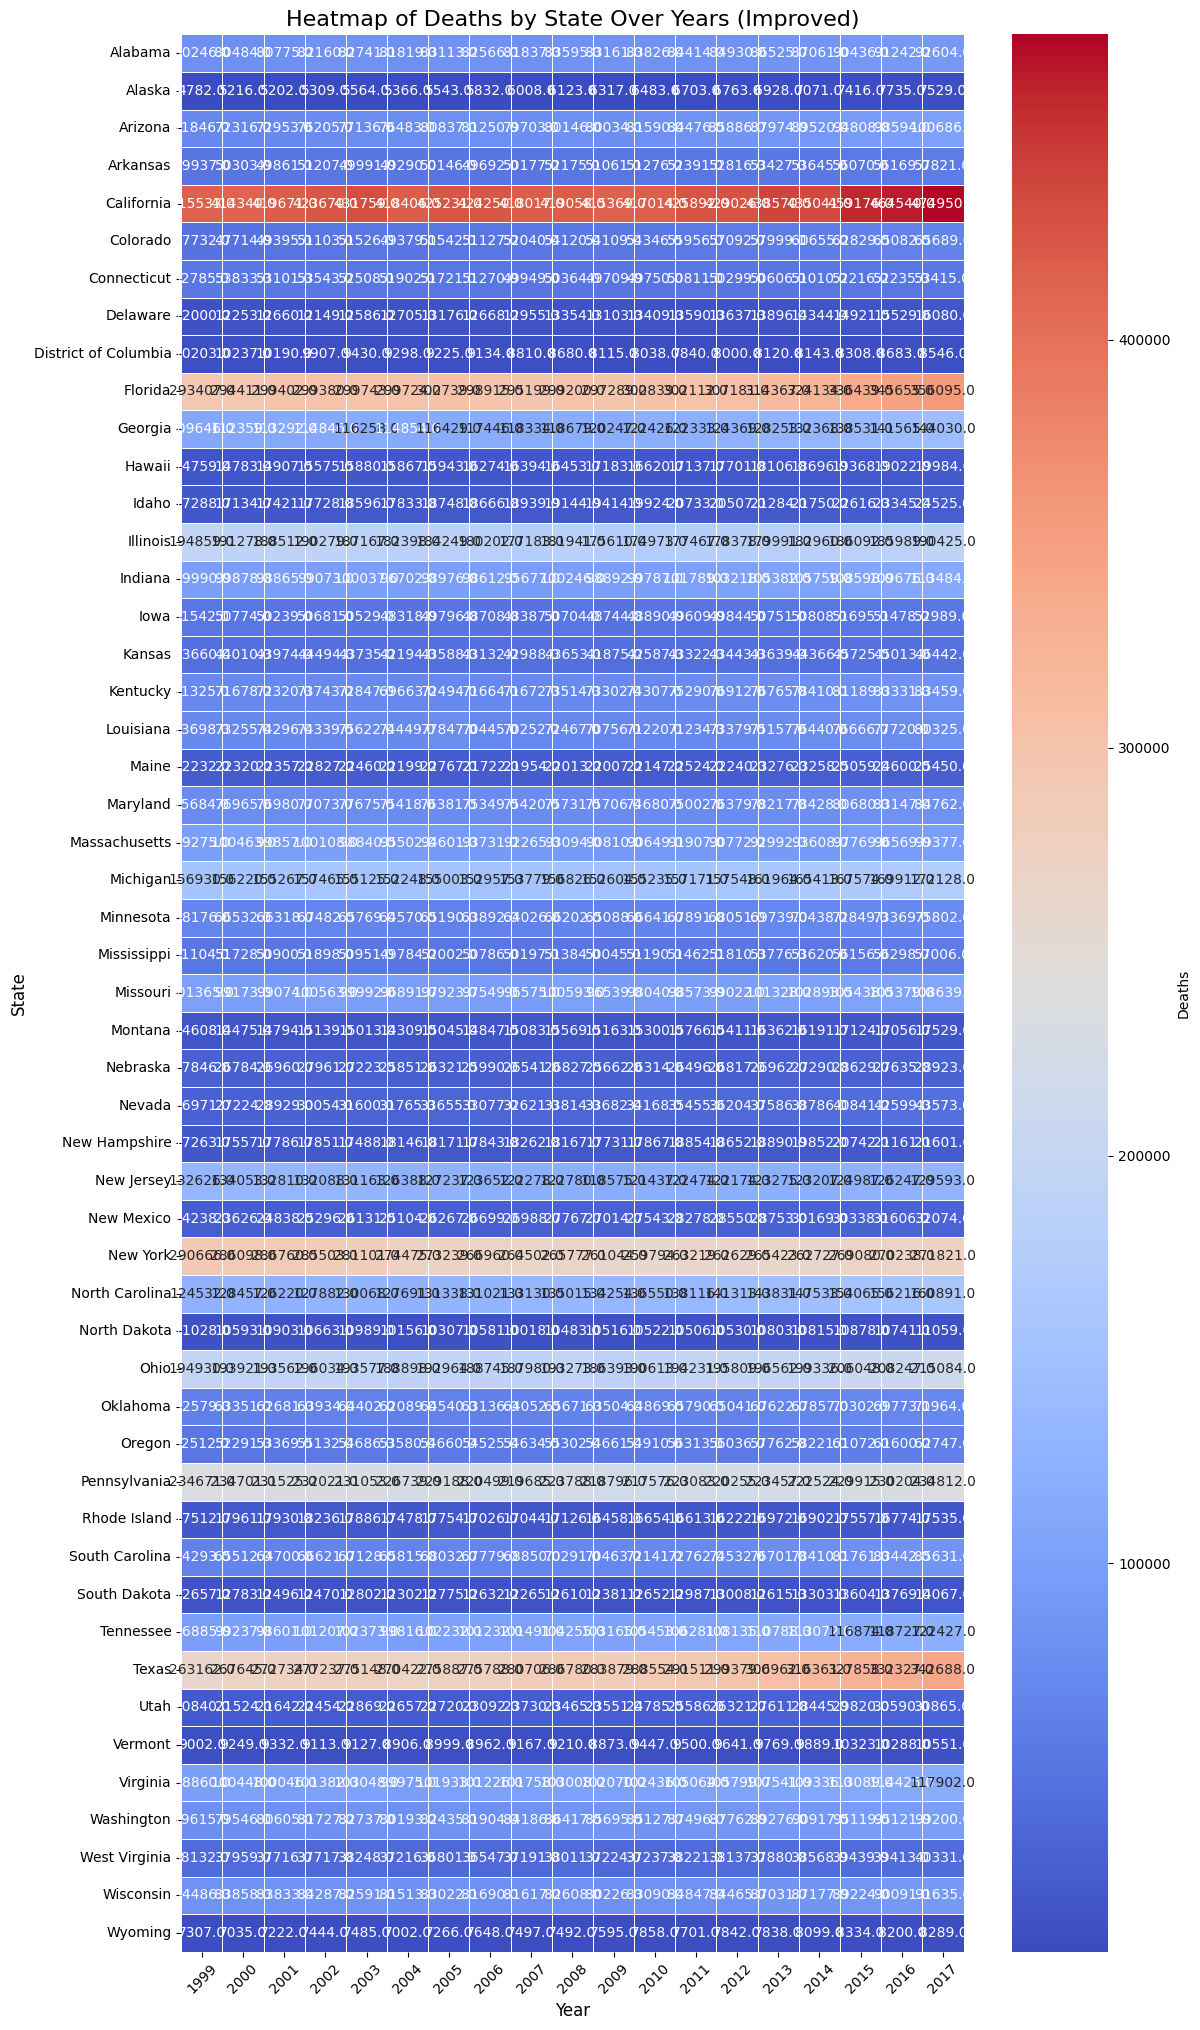

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# import ace_tools as tools  # For displaying the dataframe

# Load dataset
df = pd.read_csv('../data/processed/US_Deaths_Populations.csv', sep=',')
df_filtered = df[df["State"] != "United States"]

# Aggregate deaths by State and Year
state_year_deaths = df_filtered.groupby(["State", "Year"])["Deaths"].sum().unstack()

# Display aggregated data
# tools.display_dataframe_to_user(name="State-Year Deaths Data", dataframe=state_year_deaths_filtered)

# Set a better color palette and annotation format
plt.figure(figsize=(12, len(state_year_deaths) * 0.4))
sns.heatmap(
    state_year_deaths, 
    cmap="coolwarm", 
    linewidths=0.5, 
    annot=True, 
    fmt=".1f", 
    cbar_kws={'label': 'Deaths'}
)

plt.title("Heatmap of Deaths by State Over Years (Improved)", fontsize=16)
plt.xlabel("Year", fontsize=12)
plt.ylabel("State", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)

# Show the plot
plt.tight_layout()
plt.show()


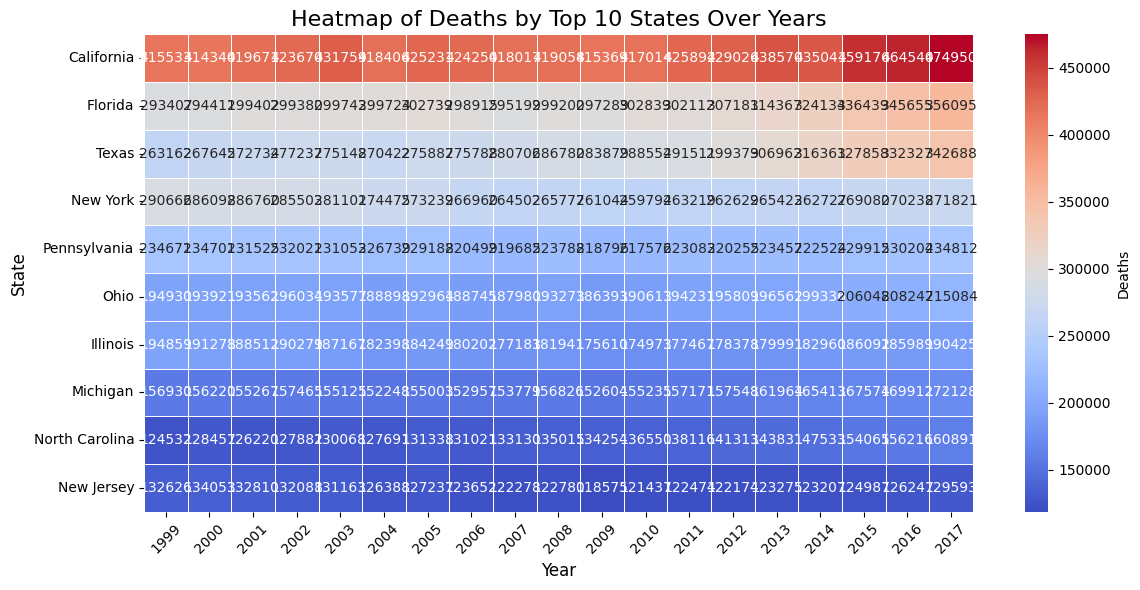

In [4]:
# Sum deaths across all years for each state to identify "hottest" states
state_totals = state_year_deaths.sum(axis=1)
top_states = state_totals.nlargest(10).index  # Get top 10 states with highest death counts

# Filter the DataFrame to include only these "hottest" states
state_year_deaths_subset = state_year_deaths.loc[top_states]

# Create an improved heatmap for the subset
plt.figure(figsize=(12, len(state_year_deaths_subset) * 0.6))
sns.heatmap(
    state_year_deaths_subset, 
    cmap="coolwarm", 
    linewidths=0.5, 
    annot=True, 
    fmt=".0f", 
    cbar_kws={'label': 'Deaths'}
)

plt.title("Heatmap of Deaths by Top 10 States Over Years", fontsize=16)
plt.xlabel("Year", fontsize=12)
plt.ylabel("State", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)

# Show the plot
plt.tight_layout()
plt.show()